In [1]:
# System communication
import os
import sys

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycountry_convert as pc

# Model assessment - custom utils for systematic scoring and comparison
# from model_cross_val_assessment import model_cross_val_assess
# from model_assessment import model_assess

# Model assessment - for at-hand scoring
from sklearn.metrics import r2_score, mean_squared_error

# Modelling
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, KFold, GroupKFold, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from scipy.sparse import lil_matrix, csr_matrix
from scipy.stats import f_oneway, chi2_contingency, randint
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor 


In [2]:
### PLEASE CHANGE THE WORKING/FILE DIRECTORY! THANK YOU
#Set the working directory
os.chdir('C:\\Users\\piotr\\OneDrive - Erasmus University Rotterdam\\Documents\\Github repositories\\Predictive-Analytics-in-Business\\Project 2\\')

In [3]:
# Define a function to assess an instance of the fitted model on the cross-validation scorer:
def model_cross_val_assess(model, X_train, y_train, model_name):
    '''
    Takes *fitted* model in args1 and applies it to the train set (predictors matrix in args2 and respone vector in args3) while also taking model's name as arg4. 
    Returns set of metrics in a dataframe object.

    ### Examplary call of the function:
    model_cross_val_assess(model, X_train, y_train, X_test, y_test, 'my_model')


    ### How to concatenate results of several models for comparison:
    a = model_cross_val_assess(model_1, X_train, y_train, 'my_model_1')
    b = model_cross_val_assess(model_2, X_train, y_train, 'my_model_2')
    c = pd.concat([a, b], axis=1)
    '''
    import pandas as pd
    import numpy as np
    import locale
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
    from sklearn.model_selection import cross_val_score

    def get_num_columns(X):
        if isinstance(X, pd.DataFrame):
            return len(X.columns)
        elif isinstance(X, np.ndarray):
            return X.shape[1]
        else:
            raise TypeError('X must be a pandas DataFrame or a NumPy array')

    scores_dict = {}

    # Use cross-validation to evaluate the model on the training data
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

    # Calculate the mean and standard deviation of the cross-validation scores
    mean_score = -scores.mean()
    std_score = scores.std()
    coef_variation = std_score / mean_score

    ## Additionally metrics for assessment on train set
    # R2 score
    y_pred = model.predict(X_train)
    r2 = r2_score(y_train, y_pred)

    # Adjusted R2
    p = get_num_columns(X_train)
    n = len(y_train)
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

    # Now return the metrics as the dict
    scores_dict[model_name] = [r2, adj_r2, mean_score, std_score, coef_variation]

    df_train_eval = pd.DataFrame(data=scores_dict, index=['r2', 'adj_r2', 'mean_cv_rmse', 'std_cv_rmse', 'coef_of_var'])
    
    # Set float_format to display numbers without scientific notation and with thousand separators
    locale.setlocale(locale.LC_ALL, '')  # Set the locale to the user's default locale
    pd.options.display.float_format = lambda x: format(locale.atof(f"{x:.1f}"), ',') if abs(x) > 999 else f"{x:.4f}"
    # in case the thousand separator is displaying incorrectly, please comment out/delete the above 2 lines and use uncomment this line:
    # pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    
    return df_train_eval

In [4]:
# Define a function to assess an instance of the fitted model on the test set:
def model_assess(model, X_test, y_test, model_name):
    '''
    Takes *fitted* model in args1 and applies it to the test set (predictors matrix in args2 and respone vector in args3) while also taking model's name as arg4. 
    Returns set of metrics in a dataframe object.

    ### Examplary call of the function:
    model_assess(model, X_test, y_test, 'my_model')

    
    ### How to concatenate results of several models for comparison:
    a = model_assess(model_1, X_test, y_test, 'my_model_1')
    b = model_assess(model_2, X_test, y_test, 'my_model_2')
    c = pd.concat([a, b], axis=1)
    '''
    import pandas as pd
    import numpy as np
    import locale
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

    def get_num_columns(X):
        if isinstance(X, pd.DataFrame):
            return len(X.columns)
        elif isinstance(X, np.ndarray):
            return X.shape[1]
        else:
            raise TypeError('X must be a pandas DataFrame or a NumPy array')

    scores_dict = {}

    # Access predictions of the fitted model on test data
    y_pred = model.predict(X_test)

    ## Metrics
    # R2 score
    r2 = r2_score(y_test, y_pred)

    # Adjusted R2
    p = get_num_columns(X_test)
    n = len(y_test)
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

    # RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # MAE
    mae = mean_absolute_error(y_test, y_pred)

    # MAPE
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Now return the metrics as the dict
    scores_dict[model_name] = [r2, adj_r2, rmse, mae, mape]

    df_eval = pd.DataFrame(data=scores_dict, index=['r2', 'adj_r2', 'rmse', 'mae', 'mape'])
    
    # Set float_format to display numbers without scientific notation and with thousand separators
    locale.setlocale(locale.LC_ALL, '')  # Set the locale to the user's default locale
    pd.options.display.float_format = lambda x: format(locale.atof(f"{x:.1f}"), ',') if abs(x) > 999 else f"{x:.4f}"
    # in case the thousand separator is displaying incorrectly, please comment out/delete the above 2 lines and use uncomment this line:
    # pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    
    return df_eval

In [5]:
## Load the data set

# Data set that was first cleaned then merged
df_final = pd.read_csv('df_full.csv')

In [6]:
df_final.columns

Index(['permalink', 'name', 'homepage_url', 'category_list', 'market',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'funding_round_permalink', 'funding_round_type',
       'funding_round_code', 'funded_at', 'funded_month', 'funded_quarter',
       'funded_year', 'raised_amount_usd', 'acquirer_permalink',
       'acquirer_name', 'acquirer_category_list', 'acquirer_market',
       'acquirer_country_code', 'acquirer_state_code', 'acquirer_region',
       'acquirer_city', 'acquired_at', 'acquired_month', 'acquired_quarter',
       'acquired_year', 'price_amount', 'price_currency_code',
       'investor_permalink', 'investor_name', 'investor_country_code',
       'investor_region', 'investor_city'],
      dtype='object')

In [7]:
def reorder_columns(df, desired_order):
    """
    Reorder the columns of a DataFrame according to a specified order.

    Parameters:
    df (pd.DataFrame): The DataFrame to be reordered.
    desired_order (list): The desired order of the columns.

    Returns:
    pd.DataFrame: DataFrame with columns reordered.
    """
    # Filter out columns that are not in the DataFrame
    final_order = [col for col in desired_order if col in df.columns]

    # Reorder the DataFrame
    return df[final_order]

# Define the desired column order
desired_order = ['permalink', 'name', 'homepage_url', 'category_list', 'state_code',
                 'founded_at', 'first_funding_at', 'last_funding_at',
                 'funding_round_permalink', 'funded_at', 'acquirer_permalink',
                 'acquirer_name', 'acquirer_category_list', 'acquirer_market',
                 'acquirer_country_code', 'acquirer_state_code', 'acquirer_region',
                 'acquirer_city', 'acquired_at', 'acquired_month', 'acquired_quarter',
                 'acquired_year', 'investor_permalink', 'investor_name',
                 'funding_total_usd', 'market', 'status', 'country_code', 'region',
                 'city', 'funding_rounds', 'funding_round_type', 'funding_round_code',
                 'funded_month', 'funded_quarter', 'funded_year', 'raised_amount_usd',
                 'price_amount', 'price_currency_code', 'investor_country_code',
                 'investor_region', 'investor_city']

# Example usage:
df_final = reorder_columns(df_final, desired_order)

In [8]:
df_final.columns

Index(['permalink', 'name', 'homepage_url', 'category_list', 'state_code',
       'founded_at', 'first_funding_at', 'last_funding_at',
       'funding_round_permalink', 'funded_at', 'acquirer_permalink',
       'acquirer_name', 'acquirer_category_list', 'acquirer_market',
       'acquirer_country_code', 'acquirer_state_code', 'acquirer_region',
       'acquirer_city', 'acquired_at', 'acquired_month', 'acquired_quarter',
       'acquired_year', 'investor_permalink', 'investor_name',
       'funding_total_usd', 'market', 'status', 'country_code', 'region',
       'city', 'funding_rounds', 'funding_round_type', 'funding_round_code',
       'funded_month', 'funded_quarter', 'funded_year', 'raised_amount_usd',
       'price_amount', 'price_currency_code', 'investor_country_code',
       'investor_region', 'investor_city'],
      dtype='object')

In [9]:
df_final.shape

(105118, 42)

In [10]:
#df final Na count
df_final.isna().sum()

permalink                      0
name                           0
homepage_url                3387
category_list               2191
state_code                     0
founded_at                     0
first_funding_at               0
last_funding_at                0
funding_round_permalink        0
funded_at                      6
acquirer_permalink             0
acquirer_name                  0
acquirer_category_list         0
acquirer_market                0
acquirer_country_code          0
acquirer_state_code            0
acquirer_region                0
acquirer_city                  0
acquired_at                91791
acquired_month             91791
acquired_quarter           91791
acquired_year              91791
investor_permalink             0
investor_name                  0
funding_total_usd              0
market                      2196
status                         0
country_code                4956
region                      4956
city                        5720
funding_ro

In [11]:
# To-int-to-str dtype for date-related features
#Drop NA in the three columns
df_final = df_final.dropna(subset=['funded_month', 'funded_quarter', 'funded_year'])
df_final['funded_month'] = df_final['funded_month'].astype('int64').astype('str')
df_final['funded_quarter'] = df_final['funded_quarter'].astype('int64').astype('str')
df_final['funded_year'] = df_final['funded_year'].astype('int64').astype('str')

In [12]:
df_final.shape

(105112, 42)

# Modelling

## Linear models

In [13]:
# Small cleaning for ID/timestamp type-of columns and columns with NaN
df_final_linear = df_final.drop(columns=['homepage_url', 'category_list', 'name', 'investor_permalink', 'price_amount',
                       'acquirer_permalink', 'acquired_at', 'acquired_month', 'acquired_quarter', 'acquired_year', 
                       'founded_at', 'first_funding_at', 'last_funding_at','funding_round_permalink', 'funded_at'])

df_final_linear.reset_index(drop=True, inplace=True)

# Move target to the second column position for convenience
df_final_linear.insert(1, 'funding_total_usd', df_final_linear.pop('funding_total_usd'))

In [14]:
# Further cleaning - customizable; to explore tilts in covariates
df_final_linear = df_final_linear.drop(columns=['price_currency_code', 'acquirer_state_code', 'state_code'])
df_final_linear.reset_index(drop=True, inplace=True)

Drop the NA's

In [20]:
#df_final NA count
df_final_linear.isna().sum()

permalink                     0
funding_total_usd             0
acquirer_name                 0
acquirer_category_list        0
acquirer_market               0
acquirer_country_code         0
acquirer_region               0
acquirer_city                 0
investor_name                 0
market                     2196
status                        0
country_code               4955
region                     4955
city                       5719
funding_rounds                0
funding_round_type            0
funding_round_code            0
funded_month                  0
funded_quarter                0
funded_year                   0
raised_amount_usd         11526
investor_country_code         0
investor_region               0
investor_city                 0
dtype: int64

In [ ]:
#Replace 

Split into training and test set (80/20)

In [15]:
splitter = GroupShuffleSplit(test_size=0.20, n_splits=1, random_state = 123)
split = splitter.split(df_final_linear, groups=df_final_linear['permalink'])
train_idx, test_idx = next(split)

train = df_final_linear.iloc[train_idx]
test = df_final_linear.iloc[test_idx]

X_train, y_train = train.iloc[:, train.columns.get_loc('acquirer_name'):], train.iloc[:, train.columns.get_loc('funding_total_usd')]
X_test, y_test = test.iloc[:, test.columns.get_loc('acquirer_name'):], test.iloc[:, test.columns.get_loc('funding_total_usd')]

#### Linear regression

In [16]:
# Continuous variables are stored in a list called continuous_vars
# Categorical variables are stored in a list called categorical_vars

# Get the column names of the continuous and categorical variables
continuous_vars = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
categorical_vars = list(X_train.select_dtypes(include=['object', 'datetime64[ns]']).columns)

In [17]:
# Define preprocessing steps for continuous variables
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing steps for categorical variables
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [18]:
# Combine noww
preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', continuous_transformer, continuous_vars),
        ('categorical', categorical_transformer, categorical_vars)
    ])

In [19]:
# Fit linear regression model with preprocessor
model_linreg_f = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model_linreg_f.fit(X_train, y_train)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [15]:
# Cross-validation scores on train sets
lin_a_cv = model_cross_val_assess(model_linreg_f, X_train, y_train, 'model_linreg_f')
# ---------
lin_a_cv

,model_linreg_f
r2,0.2803
adj_r2,0.2802
mean_cv_rmse,"98,713,004.7"
std_cv_rmse,"14,774,223.2"
coef_of_var,0.1497


In [16]:
# Performance on test set
lin_a_test = model_assess(model_linreg_f, X_test, y_test, 'model_linreg_f')
# ---------
lin_a_test

,model_linreg_f
r2,0.0291
adj_r2,0.0287
rmse,"208,478,958.4"
mae,"44,570,964.0"
mape,6.969043369825303e+21


In [25]:
# Get the feature names for the one-hot encoded variables
onehot_columns = preprocessor.named_transformers_[
    'categorical'].named_steps['onehot'].get_feature_names_out(categorical_vars)

# Combine the continuous variable names and one-hot encoded variable names
feature_names = continuous_vars + list(onehot_columns)

# Get the coefficients and feature importances
coefficients = model_linreg_f.named_steps['regressor'].coef_
importances = coefficients

# Table of feature importances
importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': importances})

# Sort df by importance score
importance_df = importance_df.sort_values('Importance', ascending=False)

# Most important features put together
print("Most influential scores, both sides:")
a_a = importance_df.head(30)
b_b = importance_df.tail(30)
c_c = pd.concat([a_a, b_b], axis=0)
# ---------
c_c

Most influential scores, both sides:


,Feature,Importance
10594,investor_name_Marlin Equity Partners,"2,515,557,181.0"
8157,investor_name_BrightHouse,"1,953,755,348.2"
5889,city_Lincolnshire,"1,675,717,180.6"
12317,investor_name_Sprint Nextel,"1,004,612,664.9"
6912,city_The Hague,"970,299,409.0"
8969,investor_name_Eagle River Holdings,"951,545,013.9"
1018,acquirer_name_Sprint Nextel,"937,594,816.1"
2817,acquirer_city_Overland Park,"937,594,816.1"
9390,investor_name_GI Partners,"759,834,407.9"
8557,investor_name_Comcast,"712,183,468.8"


#### Regularized (Ridge) regression

In [26]:
# Define a parameter grid for Ridge regression
ridge_param_grid = {
    'regressor__alpha': list(np.arange(500, 5500, step=500))
}

# Create a dictionary of regressors
regressors = {
    'ridge': Ridge()
}

# Create a dictionary of parameter grids
param_grids = {
    'ridge': ridge_param_grid
}

In [27]:
# Create an empty dictionary to store the results
results_regularized = {}

# Loop over the regressors
for regressor_name, regressor in regressors.items():

    # Create a pipeline for each regressor
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    # Create a grid search object for the regressor
    grid_search = GridSearchCV(
        pipeline, param_grids[regressor_name], cv=5, n_jobs=-1)

    # Fit the grid search object on the training data
    grid_search.fit(X_train, y_train)

    # Store the results in the dictionary
    results_regularized[regressor_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
    }

    # Print the results
    print(regressor_name, 'best parameters:',
          results_regularized[regressor_name]['best_params'])
    print(regressor_name, 'best training R2 score:',
          results_regularized[regressor_name]['best_score'])

ridge best parameters: {'regressor__alpha': 1000}
ridge best training R2 score: 0.19420906231729546


In [28]:
# Extract the best fitted model
model_ridge_f = grid_search.best_estimator_

In [29]:
# Cross-validation scores on train sets
lin_b_cv = model_cross_val_assess(model_ridge_f, X_train, y_train, 'model_ridge_f')
# ---------
lin_b_cv

,model_ridge_f
r2,0.2382
adj_r2,0.2380
mean_cv_rmse,"111,707,376.5"
std_cv_rmse,"54,303,890.5"
coef_of_var,0.4861


In [30]:
# Performance on test set
lin_b_test = model_assess(model_ridge_f, X_test, y_test, 'model_ridge_f')
# ---------
lin_b_cv

,model_ridge_f
r2,0.2382
adj_r2,0.2380
mean_cv_rmse,"111,707,376.5"
std_cv_rmse,"54,303,890.5"
coef_of_var,0.4861


#### SVD with linear regression - tuned components

In [ ]:
# # This pipeline was tuned before, yielded 22 components as best hp

# # Define pipeline for TruncatedSVD and linear regression
# svd_pipe = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('svd', TruncatedSVD(random_state=0)),
#     ('regressor', LinearRegression())
# ])

# # Define the parameter grid for TruncatedSVD
# param_grid = {'svd__n_components': range(1, len(continuous_vars) + len(categorical_vars) + 1)}

# # Define the cross-validation strategy
# cv_svd = KFold(n_splits=5, shuffle=True, random_state=123)

In [ ]:
# # Perform grid search with cross-validation
# grid_search = GridSearchCV(svd_pipe, param_grid=param_grid, cv=cv_svd, scoring='r2', n_jobs=-1)
# grid_search.fit(X_train, y_train)

In [ ]:
# # Print the best parameters and the best score
# print("Best number of components:", grid_search.best_params_['svd__n_components'])
# print("Best training R2 score:", grid_search.best_score_)

In [ ]:
# # Get the best estimator from the grid search
# model_svd_f = grid_search.best_estimator_

# # Fit the best estimator on the training data
# model_svd_f.fit(X_train, y_train)

In [ ]:
# # Get the optimal number of components from the grid search
# optimal_n_components = grid_search.best_params_['svd__n_components']

# # Get the SVD step from the pipeline
# svd_step = model_svd_f.named_steps['svd']

# # Get the explained variance ratio of the principal components
# explained_variance = svd_step.explained_variance_ratio_.cumsum()

# # Get the number of components required to capture the threshold of variance
# n_components = len(explained_variance) # default value

# # Make the scree plot
# plt.plot((explained_variance * 100))
# plt.axvline(x=optimal_n_components-1, linestyle='--', color='r', label='Optimal Components')
# plt.xticks(np.arange(0, n_components), rotation=90)
# plt.xlabel("Number of components (Dimensions)")
# plt.ylabel("Explained variance (%)")
# plt.legend()


In [ ]:
# Define pipeline for TruncatedSVD and linear regression
model_svd_f = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(random_state=0, n_components=22)),
    ('regressor', LinearRegression())
])

In [ ]:
# Fit the best estimator on the training data
model_svd_f.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['funding_rounds',
                                                   'raised_amount_usd']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['acquirer_name',
                                                   'acquirer_category_list',
                                                   'acquirer_market',
                                                   'acquirer_country_code',
                                                   '

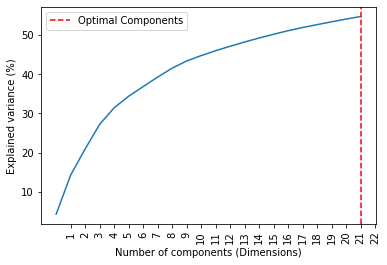

In [ ]:
# Get the optimal number of components
optimal_n_components = model_svd_f.n_features_in_

# Get the explained variance ratio of the principal components
explained_variance = model_svd_f.named_steps['svd'].explained_variance_ratio_.cumsum()

# Get the number of components required to capture the threshold of variance
n_components = len(explained_variance) # default value

# Make the scree plot
plt.plot((explained_variance * 100))
plt.axvline(x=optimal_n_components-1, linestyle='--', color='r', label='Optimal Components')
plt.xticks(np.arange(1, n_components+1), rotation=90)
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")
plt.legend()


In [ ]:
# Cross-validation scores on train sets
lin_c_cv = model_cross_val_assess(model_svd_f, X_train, y_train, 'model_svd_f')
# ---------
lin_c_cv

,model_svd_f
r2,0.4755
adj_r2,0.4754
mean_cv_rmse,"82,698,018.7"
std_cv_rmse,"26,154,785.9"
coef_of_var,0.3163


In [ ]:
# Performance on test set
lin_c_test = model_assess(model_svd_f, X_test, y_test, 'model_svd_f')
# ---------
lin_c_test

,model_svd_f
r2,0.6391
adj_r2,0.6387
rmse,"117,498,887.3"
mae,"30,138,338.3"
mape,116.1943


#### Model's comparison

In [ ]:
# Compare performance - train sets with cross-validation scoring against RMSE
linear_performance_cross_val = pd.concat([lin_a_cv, lin_b_cv, lin_c_cv], axis=1)
# ---------
linear_performance_cross_val

,model_linreg_f,model_ridge_f,model_svd_f
r2,0.6545,0.4957,0.4755
adj_r2,0.6544,0.4956,0.4754
mean_cv_rmse,"94,765,183.8","82,310,965.2","82,698,018.7"
std_cv_rmse,"22,744,698.6","26,801,694.0","26,154,785.9"
coef_of_var,0.2400,0.3256,0.3163


In [ ]:
# Compare performance - test sets
linear_performance_test = pd.concat([lin_a_test, lin_b_test, lin_c_test], axis=1)
# ---------
linear_performance_test

,model_linreg_f,model_ridge_f,model_svd_f
r2,0.5702,0.6283,0.6391
adj_r2,0.5697,0.6279,0.6387
rmse,"128,229,239.3","119,235,127.6","117,498,887.3"
mae,"40,203,041.0","29,436,624.2","30,138,338.3"
mape,125.3670,111.2556,116.1943


## Non-linear models

### Gradient Boosting

#### Using the entire dataset

In [ ]:
# First defining the variables to discard. We discard price amount and price currency code here, because it is missing for the majority of the observations.
to_remove = ['name','homepage_url', 'category_list', 'first_funding_at', 'last_funding_at', 'founded_at',
             'funding_round_permalink', 'funded_at','investor_permalink', 'investor_name', 'acquirer_permalink', 
             'acquirer_name', 'acquirer_category_list','acquirer_state_code', 'acquirer_city', 'acquired_at', 
            'acquired_month', 'acquired_quarter', 'acquired_year', 'acquirer_country_code', 'acquirer_region', 'state_code',
            'price_amount', 'price_currency_code']

In [ ]:
# Here we are not including permalink in the variables to discard as we will use this variable to define our train test split and our cross validation fold
# As such this variable will be removed after cross-validation folds are defined
df_model = df_final.drop(to_remove, axis = 1)
df_model.drop_duplicates(inplace = True) # there was a large number of duplicates after dropping the other columns - around 10 k or so
df_model.reset_index(inplace=True, drop=True)

# defining groups based on permalink for the splitting later
groups = df_model['permalink']

In [ ]:
X = df_model.drop('funding_total_usd', axis = 1)
y = df_model['funding_total_usd']

In [ ]:
# The new train-test split using groups based on permalinks - basically so companies don't appear in both train and test sets, which would cause data leakage
splitter = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 123)
train_idx, test_idx = next(splitter.split(X,y,groups))

X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

In [ ]:
# Defining the groups for cross-validation later if wanted and dropping the extra variable permalink now
groups_cv = X_train['permalink']
X_train.drop('permalink', axis = 1, inplace = True)
X_test.drop('permalink', axis = 1, inplace = True)

C:\Users\oleek\AppData\Local\Temp\ipykernel_20864\1943101124.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop('permalink', axis = 1, inplace = True)
C:\Users\oleek\AppData\Local\Temp\ipykernel_20864\1943101124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('permalink', axis = 1, inplace = True)


In [ ]:
# Continuous variables are stored in a list called continuous_vars
# Categorical variables are stored in a list called categorical_vars}

# Get the column names of the continuous and categorical variables
continuous_vars = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
categorical_vars = list(X_train.select_dtypes(include=['object', 'datetime64[ns]']).columns)

In [ ]:
# Define preprocessing steps for continuous variables
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing steps for categorical variables
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Combine noww
preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', continuous_transformer, continuous_vars),
        ('categorical', categorical_transformer, categorical_vars)
    ])

In [ ]:
# Creating the model using a pipeline 
model_base_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state = 1541, n_estimators = 200, min_samples_split = 5, max_features = 1500, max_depth = 2, learning_rate = 0.1)) #for randomized search we removed all the parameters except random state
    #results of randomized cross validation:
     #{'regressor__n_estimators': 200,
     # 'regressor__min_samples_split': 5,
     # 'regressor__max_features': 1500,
     # 'regressor__max_depth': 2,
     # 'regressor__learning_rate': 0.1}
])

In [ ]:
# Now that our model pipeline is ready, we apply cross-validation. Here we choose to do random search instead of the exhaustive grid search to save computational resources. 
# This to be used for the CV parameter in the random search/grid search function - lets the function know to also split the folds based on the groups of companies
gkf = GroupKFold(n_splits = 5)

# # Tuning grid for cross-validation
# gb_grid = {'regressor__n_estimators': [100, 200,400,600,800],
#             'regressor__max_features': ['sqrt','log2', 500, 1000, 1500],
#             'regressor__learning_rate':[.001, .01, .05, .1, 0.5],
#             'regressor__max_depth': [2,3,6,8,10],
#             'regressor__min_samples_split': [2,3,5]}

# # Here the random search function is defined with 150 iterations of different combinations from the grid
# random_search  = RandomizedSearchCV(n_iter = 25, estimator = model_base_gb,param_distributions= gb_grid, cv = gkf,
#                                     n_jobs = -1, verbose = 2, scoring = 'neg_root_mean_squared_error', random_state = 2)



In [ ]:
# random_search.fit(X_train, y_train, groups = groups_cv)

In [ ]:
# random_search.best_params_

In [ ]:
# random_search.best_score_

In [ ]:
# best_random = random_search.best_estimator_

In [ ]:
# cross_val_score(best_random, X_train, y_train,scoring = 'neg_root_mean_squared_error', cv = gkf, groups = groups_cv).mean()

In [ ]:
model_base_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['funding_rounds',
                                                   'raised_amount_usd']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['acquirer_market', 'market',
                                                   'status', 'country_code',
                                                   'region', 'city',
                                                   'funding_round_type',
                                            

In [ ]:
base_gb_cv = model_cross_val_assess(model_base_gb, X_train, y_train, 'base_gb')
# ---------
base_gb_cv

,base_gb
r2,0.7546
adj_r2,0.7545
mean_cv_rmse,"85,822,880.6"
std_cv_rmse,"25,361,034.4"
coef_of_var,0.2955


In [ ]:
base_gb_test = model_assess(model_base_gb, X_test, y_test, 'base_gb')
# ---------
base_gb_test

,base_gb
r2,0.5037
adj_r2,0.5033
rmse,"141,670,000.0"
mae,"27,204,562.1"
mape,43.7782


#### Using one row per company - removing duplicate entries from the merging

In [ ]:
# Seeing the large discrepancy between the cross-validation score and the test score, we can see that the previous model potentially overfits on the training data. 
# This makes sense since there are multiple rows per company in the dataet, with only a few variables differentiating (usually investor or round information). 
# This can cause the model to learn the characteristics of the companies in the train set very well but not in the test set. 
# To test this, we can see if removing the duplicate rows per company improves the performance of the model.

In [ ]:
df_nodup = df_final.drop_duplicates(subset = ['permalink'])
df_nodup.shape

(28719, 42)

In [ ]:
to_remove = ['permalink','name','homepage_url', 'category_list', 'first_funding_at', 'last_funding_at', 'founded_at',
             'funding_round_permalink', 'funded_at','investor_permalink', 'investor_name', 'acquirer_permalink', 
             'acquirer_name', 'acquirer_category_list','acquirer_state_code', 'acquirer_city', 'acquired_at', 
            'acquired_month', 'acquired_quarter', 'acquired_year', 'acquirer_country_code', 'acquirer_region', 'state_code',
            'price_amount', 'price_currency_code']

In [ ]:
df_model = df_nodup.drop(to_remove, axis = 1)
df_model.shape

(28719, 17)

In [ ]:
X = df_model.drop('funding_total_usd', axis = 1)
y = df_model['funding_total_usd']

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1756) 

In [ ]:
# Fit gradient boosting regressor model with preprocessor
model_nodup_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state = 1541, n_estimators = 400, min_samples_split = 2, max_features = 1500, max_depth = 3, learning_rate = 0.1))
     #these parameters are taken from a previous random search with the same parameter grid as before
])

model_nodup_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['funding_rounds',
                                                   'raised_amount_usd']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['acquirer_market', 'market',
                                                   'status', 'country_code',
                                                   'region', 'city',
                                                   'funding_round_type',
                                            

In [ ]:
nodup_gb_cv = model_cross_val_assess(model_nodup_gb, X_train, y_train, 'nodup_gb')
# ---------
nodup_gb_cv

,nodup_gb
r2,0.9287
adj_r2,0.9286
mean_cv_rmse,"58,504,264.1"
std_cv_rmse,"21,694,606.1"
coef_of_var,0.3708


In [ ]:
nodup_gb_test = model_assess(model_nodup_gb, X_test, y_test, 'nodup_gb')
# ---------
nodup_gb_test

,nodup_gb
r2,0.4604
adj_r2,0.4589
rmse,"48,820,755.0"
mae,"8,949,026.6"
mape,40.5325


In [ ]:
# As can be seen, the performance is significantly better. This confirms our previous hypothesis. 

#### Using one row per company and minor feature engineering

In [ ]:
# Let's isolate the categorical variables of interest (so all categorical variables except for the identification variables such as permalinks and names).
categorical_vars = list(df_nodup.select_dtypes(include=['object', 'datetime64[ns]']).columns)

In [ ]:
categorical_vars = [categorical_vars[4],*categorical_vars[13:18],*categorical_vars[21:]]
categorical_vars

['state_code',
 'acquirer_market',
 'acquirer_country_code',
 'acquirer_state_code',
 'acquirer_region',
 'acquirer_city',
 'market',
 'status',
 'country_code',
 'region',
 'city',
 'funding_round_type',
 'funding_round_code',
 'funded_month',
 'funded_quarter',
 'funded_year',
 'price_currency_code',
 'investor_country_code',
 'investor_region',
 'investor_city']

In [ ]:
# Let's see the relationship between the categorical variables and the target variable using an ANOVA test. If the p-value is lower than a threshold (0.1). 
# It means that the average target variable (total funding) is significantly different across categories.

# Calculate ANOVA
for i in categorical_vars:
    grouped_data = df_nodup.groupby(i)['funding_total_usd']
    f_value, p_value = f_oneway(*[grouped_data.get_group(x) for x in grouped_data.groups])
    print(f'F-value - {i}:', f_value)
    print(f'p-value - {i}:', p_value)

# Print results

F-value - state_code: 2.5801975913914896
p-value - state_code: 2.023364770583877e-10
F-value - acquirer_market: 1.3449851222862135
p-value - acquirer_market: 0.00014217922167495032
F-value - acquirer_country_code: 1.3814935996568338
p-value - acquirer_country_code: 0.05702718253911847
F-value - acquirer_state_code: 30.8568967181551
p-value - acquirer_state_code: 3.274258399631912e-271
F-value - acquirer_region: 8.128112664881998
p-value - acquirer_region: 3.609285818657157e-218
F-value - acquirer_city: 7.923472579179499
p-value - acquirer_city: 0.0
F-value - market: 1.217852977735501
p-value - market: 8.138075699482296e-05
F-value - status: 15.426300571235867
p-value - status: 5.036671859193323e-10
F-value - country_code: 1.9146062842219238
p-value - country_code: 7.442739349195739e-08
F-value - region: 0.6080592284313217
p-value - region: 0.9999999999999999
F-value - city: 0.679836307619032
p-value - city: 0.9999999999999999
F-value - funding_round_type: 154.09915958012752
p-value - f

In [ ]:
# All variables besides acquirer country code, region, city and funded quarter seem to be correlated with the target variable. 
# This may be because for some of these variables there are only a few observations belonging to a particular category, 
# so this would then skew the average total funding per category (e.g. city) a lot.

# Let's group up smaller categories into the 'other' category. For these categories, the model does not have enough data to establish a proper relationship 
# so this should help the performance. Here we choose to group all categories with 5 observations or less.

# When we do this, region and city become now correlated with the target variable (p-values < 0.1). 
# Funded quarter is still strongly unrelated so it is dropped (added to the to_remove list).

In [ ]:
for i in categorical_vars:
    counts = df_nodup[i].value_counts()
    unique_values = counts[counts <= 5].index.tolist()
    df_nodup.loc[df_nodup[i].isin(unique_values), i] = 'other'

In [ ]:
to_remove = ['permalink','name','homepage_url', 'category_list', 'first_funding_at', 'last_funding_at', 'founded_at',
             'funding_round_permalink', 'funded_at','investor_permalink', 'investor_name', 'acquirer_permalink', 
             'acquirer_name', 'acquirer_category_list','acquirer_state_code', 'acquirer_city', 'acquired_at', 
            'acquired_month', 'acquired_quarter', 'acquired_year', 'acquirer_country_code', 'acquirer_region', 'state_code',
            'price_amount', 'price_currency_code', 'funded_quarter']

In [ ]:
# Now just repeat
df_model = df_nodup.drop(to_remove, axis = 1)
df_model.shape

(28719, 16)

In [ ]:
X = df_model.drop('funding_total_usd', axis = 1)
y = df_model['funding_total_usd']

In [ ]:
# Continuous variables are stored in a list called continuous_vars
# Categorical variables are stored in a list called categorical_vars}

# Get the column names of the continuous and categorical variables
continuous_vars = list(X.select_dtypes(include=['int64', 'float64']).columns)
categorical_vars = list(X.select_dtypes(include=['object', 'datetime64[ns]']).columns)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1756)

In [ ]:
# Define preprocessing steps for continuous variables
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing steps for categorical variables
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Combine noww
preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', continuous_transformer, continuous_vars),
        ('categorical', categorical_transformer, categorical_vars)
    ])

In [ ]:
# Fit gradient boosting regressor model with preprocessor
model_catgroup_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state = 1541, n_estimators = 400, min_samples_split = 2, max_features = 1500, max_depth = 3, learning_rate = 0.1))
    # same hyperparameters as above
])

model_catgroup_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['funding_rounds',
                                                   'raised_amount_usd']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['acquirer_market', 'market',
                                                   'status', 'country_code',
                                                   'region', 'city',
                                                   'funding_round_type',
                                            

In [ ]:
catgroup_gb_cv = model_cross_val_assess(model_catgroup_gb, X_train, y_train,'catgroup_gb')
# ---------
catgroup_gb_cv

,catgroup_gb
r2,0.9395
adj_r2,0.9394
mean_cv_rmse,"54,633,112.1"
std_cv_rmse,"24,192,030.0"
coef_of_var,0.4428


In [ ]:
catgroup_gb_test = model_assess(model_catgroup_gb, X_test, y_test, 'catgroup_gb')
# ---------
catgroup_gb_test

,catgroup_gb
r2,0.5816
adj_r2,0.5805
rmse,"42,987,381.1"
mae,"8,729,483.5"
mape,28.1006


In [ ]:
# The performance on the test set increased considerably, with a decrease in RMSE by about 6 million dollars 
# and the cross-validation performance is also considerably better. 
# Therefore, we decide to keep these changes.

#### Flattening the dataset while retaining as much information as possible

In [ ]:
# Now that we have established that the model performs significantly better with a flatter representation, 
# where each company is represented by one row, we will now flatten the dataset in the same way 
# but this time retaining all the original information from the base dataset.

In [ ]:
# For this, we will first convert the funding date information into categorical/object variables.
# Set up new object
df_flat = df_final.copy()

In [ ]:
# We will also use a function we used above to group up the small populated categories into the value 'other':
for i in categorical_vars:
    counts = df_nodup[i].value_counts()
    unique_values = counts[counts <= 5].index.tolist()
    df_flat.loc[df_flat[i].isin(unique_values), i] = 'other'

In [ ]:
# we keep the permalink variable since it is necessary for company identification
to_remove = ['name','homepage_url', 'category_list', 'first_funding_at', 'last_funding_at', 'founded_at',
             'funding_round_permalink', 'funded_at','investor_permalink', 'investor_name', 'acquirer_permalink', 
             'acquirer_name', 'acquirer_category_list','acquirer_state_code', 'acquirer_city', 'acquired_at', 
            'acquired_month', 'acquired_quarter', 'acquired_year', 'acquirer_country_code', 'acquirer_region', 'state_code',
            'price_amount', 'price_currency_code']

In [ ]:
df_flat_model = df_flat.drop(to_remove, axis = 1)
df_flat_model.shape

(92975, 18)

In [ ]:
# Adding a prefix to each of the column values - necessary to have unique column names for later, since we will be using the values inside the table to create dummies
# loop through the columns
for col in df_flat_model.columns:
    # check if the column is a string column
    if df_flat_model[col].dtype == 'object':
        # add prefix to the values in the column
        df_flat_model[col] = col + '_' + df_flat_model[col].astype(str)

In [ ]:
string_cols = df_flat_model.select_dtypes(include=['object']).columns

# Create a dictionary of aggregation functions to apply to each column
agg_dict = {}
for col in df_flat_model.columns:
    if col in string_cols:
        # for categorical variables, put the unique values per permalink into a list
        agg_dict[col] = lambda x: x.unique().tolist()
    else:
        # for numerical variables, select the maximum raised amount variable, 
        # otherwise pick the first number (this should never happen though since we only have raised amount as a numeric variable)
        agg_dict[col] = 'max' if col == 'raised_amount_usd' else 'first'

# Group by name column and aggregate
df_flat_model = df_flat_model.groupby("permalink", as_index=False).agg(agg_dict)

# select the categorical/string columns and remove the square brackets that are generated by a list, then join them with a comma
string_cols = df_flat_model.select_dtypes(include=['object']).columns
df_flat_model[string_cols] = df_flat_model[string_cols].apply(lambda x: x.str.join(',').str.replace(r'\[|\]', ''))

C:\Users\oleek\AppData\Local\Temp\ipykernel_20864\1628429815.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df_flat_model[string_cols] = df_flat_model[string_cols].apply(lambda x: x.str.join(',').str.replace(r'\[|\]', ''))


In [ ]:
df_flat_model.drop('permalink', axis = 1, inplace = True)

In [ ]:
# create the dummy variables based on a comma separation for our categorical variables
# this applies to all categorical variables besides basic company information
dummies = ['acquirer_market', 'funding_round_type', 'funding_round_code', 'funded_month', 'funded_quarter', 'funded_year',
          'investor_country_code', 'investor_region', 'investor_city'] 

# create an empty data frame for the loop function to add the dummy variables onto
df_dummies = pd.DataFrame()

for var in dummies:
    dummies_temp = df_flat_model[var].str.get_dummies(sep = ',')
    df_dummies = pd.concat([df_dummies, dummies_temp], axis = 1)

In [ ]:
# merge it with the original dataset and drop the original variables, which the dummies are based on
df_flat_dm = pd.concat([df_flat_model, df_dummies], axis = 1)
df_flat_dm.drop(dummies, axis = 1, inplace = True)
df_flat_dm

,funding_total_usd,market,status,country_code,region,city,funding_rounds,raised_amount_usd,acquirer_market_Accounting,acquirer_market_Ad Targeting,...,investor_city_Yoqne`am `illit,investor_city_Zagreb,investor_city_Zaragoza,investor_city_Zaventem,investor_city_Zeist,investor_city_Zug,investor_city_Zurich,investor_city_Zürich,investor_city_Çan,investor_city_Écully
0,"700,000.0",market_Unknown,status_operating,country_code_USA,region_DE - Other,city_Delaware City,2,"700,000.0",0,0,...,0,0,0,0,0,0,0,0,0,0
1,"762,851.0",market_ Biotechnology,status_operating,country_code_CAN,region_Vancouver,city_Vancouver,2,"719,491.0",0,0,...,0,0,0,0,0,0,0,0,0,0
2,"10,600,000.0",market_ Analytics,status_operating,country_code_USA,region_SF Bay Area,city_Mountain View,2,"8,900,000.0",0,0,...,0,0,0,0,0,0,0,0,0,0
3,"1,150,050.0",market_ Mobile,status_operating,country_code_USA,region_SF Bay Area,city_San Francisco,3,"1,000,050.0",0,0,...,0,0,0,0,0,0,0,0,0,0
4,"40,000.0",market_ E-Commerce,status_operating,country_code_CHL,region_Santiago,city_Las Condes,1,"40,000.0",0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28714,"2,150,000.0",market_ Public Transportation,status_operating,country_code_USA,region_New York City,city_New York,1,"2,150,000.0",0,0,...,0,0,0,0,0,0,0,0,0,0
28715,"15,419,877.0",market_ Biotechnology,status_closed,country_code_MYS,region_MYS - Other,city_Damansara New Village,4,"7,991,547.0",0,0,...,0,0,0,0,0,0,0,0,0,0
28716,"2,686,600.0",market_ Biotechnology,status_operating,country_code_AUT,region_Vienna,city_Gerasdorf Bei Wien,1,"2,686,600.0",0,0,...,0,0,0,0,0,0,0,0,0,0
28717,"320,000.0",market_ Education,status_operating,country_code_GBR,region_London,city_London,1,"320,000.0",0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Let's convert the int64 data types to int16 to save memory and make it run faster.
int64_cols = df_flat_dm.select_dtypes(include = 'int64').columns
df_flat_dm[int64_cols] = df_flat_dm[int64_cols].astype('int16')

In [ ]:
X = df_flat_dm.drop('funding_total_usd', axis = 1)
y = df_flat_dm['funding_total_usd']

In [ ]:
# Continuous variables are stored in a list called continuous_vars
# Categorical variables are stored in a list called categorical_vars}

# Get the column names of the continuous and categorical variables
continuous_vars = list(X.select_dtypes(include=['float64']).columns) #we will only scale the raised amount/float variables - we don't want to scale the dummy variables already present
categorical_vars = list(X.select_dtypes(include=['object', 'datetime64[ns]']).columns)

other_vars = list(set(list(X.columns)) - set(continuous_vars) - set(categorical_vars)) #all the remaining variables

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1756) 

In [ ]:
# Define preprocessing steps for continuous variables
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
# Define preprocessing steps for categorical variables
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
#we want the other variables to stay the same - no changes
identity_transformer = Pipeline(steps=[
    ('identity', FunctionTransformer(lambda x: x))
])

In [ ]:
# Combine noww
preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', continuous_transformer, continuous_vars),
        ('categorical', categorical_transformer, categorical_vars),
        ('other', identity_transformer, other_vars)
    ])

In [ ]:
# Fit gradient boosting regressor to data
model_flat_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sparse_matrix', FunctionTransformer(lambda x: csr_matrix(x))),
    ('regressor', GradientBoostingRegressor(random_state = 1541, n_estimators = 400, min_samples_split = 2, max_depth = 3, learning_rate = 0.1))
])

model_flat_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['raised_amount_usd']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['market', 'status',
                                                   'country_code', 'region',
                                                   'city']),
                                                 ('other',
                                                  Pipeline(steps=[('identity',
                                                                 

In [ ]:
flat_gb_cv = model_cross_val_assess(model_flat_gb, X_train, y_train,'flat_gb')
# ---------
flat_gb_cv

,flat_gb
r2,0.9938
adj_r2,0.9932
mean_cv_rmse,"30,620,618.9"
std_cv_rmse,"18,713,502.9"
coef_of_var,0.6111


In [ ]:
flat_gb_cv = model_assess(model_flat_gb, X_test, y_test, 'flat_gb')
# ---------
flat_gb_cv

,flat_gb
r2,0.9025
adj_r2,0.8418
rmse,"18,335,869.7"
mae,"3,277,468.0"
mape,3.4930


In [ ]:
preprocessor.fit_transform(X_train).shape # 6430 features

(22975, 6430)

In [ ]:
# As we can see the performance is now significantly better - 
# with the RMSE on the test set falling under 20 million USD, while the cross-validation RMSE being around 30 million. 
# Now the only thing left is to perform hyperparameter tuning to get the best model possible. 

#### Hyperparameter tuning 

In [ ]:
# Now that we know this is the best performing model, we perform hyperparameter tuning again, 
# with a slightly expanded parameter grid. The tuning code is again provided below commented out 
# and the actual model is already fitted with the hyperparameters, which were found to be the best using RandomizedSearchCV.

In [ ]:
# # Fit gradient boosting regressor to data
# model_flat_tuning_gb = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('sparse_matrix', FunctionTransformer(lambda x: csr_matrix(x))),
#     ('regressor', GradientBoostingRegressor(random_state = 1541))
# ])

# #tuning grid for cross-validation
# gb_grid_final = {'regressor__n_estimators': [100, 200,400,600,800],
#             'regressor__max_features': ['sqrt','log2', 500, 2000, 4000, 'auto'],
#             'regressor__learning_rate':[.001, .01, .05, .1, 0.5],
#             'regressor__max_depth': [2,3,6,8],
#             'regressor__min_samples_split': [2,3,5]}

# #here the random search function is defined with 100 iterations of different combinations from the grid
# random_search_final  = RandomizedSearchCV(n_iter = 100, estimator = model_flat_tuning_gb,param_distributions= gb_grid_final, cv = 5,
#                                     n_jobs = -1, verbose = 2, scoring = 'neg_root_mean_squared_error', random_state = 2)


In [ ]:
# random_search_final.fit(X_train, y_train)

In [ ]:
# print(random_search_final.best_score_)
# print(random_search_final.best_params_)

In [ ]:
# tuned_gb = random_search_final.best_estimator_

In [ ]:
# the final tuned model
model_flat_tuned_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sparse_matrix', FunctionTransformer(lambda x: csr_matrix(x))),
    ('regressor', GradientBoostingRegressor(random_state = 1541, n_estimators = 600, min_samples_split = 5,
                                           max_features = 'auto', max_depth = 2, learning_rate = 0.5))
])

In [ ]:
model_flat_tuned_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['raised_amount_usd']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['market', 'status',
                                                   'country_code', 'region',
                                                   'city']),
                                                 ('other',
                                                  Pipeline(steps=[('identity',
                                                                 

In [ ]:
flat_tuned_gb_cv = model_cross_val_assess(model_flat_tuned_gb, X_train, y_train, 'flat_tuned_gb')
# ---------
flat_tuned_gb_cv

,flat_tuned_gb
r2,0.9969
adj_r2,0.9965
mean_cv_rmse,"26,642,268.7"
std_cv_rmse,"19,982,202.8"
coef_of_var,0.7500


In [ ]:
flat_tuned_gb_test = model_assess(model_flat_tuned_gb, X_test, y_test, 'flat_tuned_gb')
# ---------
flat_tuned_gb_test

,flat_tuned_gb
r2,0.9073
adj_r2,0.8496
rmse,"17,875,161.4"
mae,"3,291,717.6"
mape,4.1410


#### Model's comparison

In [ ]:
# Compare performance - train sets with cross-validation scoring against RMSE
gb_performance_cross_val = pd.concat([base_gb_cv, nodup_gb_cv, catgroup_gb_cv, flat_tuned_gb_cv], axis=1)
# ---------
gb_performance_cross_val

,base_gb,nodup_gb,catgroup_gb,flat_tuned_gb
r2,0.7546,0.9287,0.9395,0.9969
adj_r2,0.7545,0.9286,0.9394,0.9965
mean_cv_rmse,"85,822,880.6","58,504,264.1","54,633,112.1","26,642,268.7"
std_cv_rmse,"25,361,034.4","21,694,606.1","24,192,030.0","19,982,202.8"
coef_of_var,0.2955,0.3708,0.4428,0.7500


In [ ]:
# Compare performance - test sets
gb_performance_test = pd.concat([base_gb_test, nodup_gb_test, catgroup_gb_test, flat_tuned_gb_test], axis=1)
# ---------
gb_performance_test

,base_gb,nodup_gb,catgroup_gb,flat_tuned_gb
r2,0.5037,0.4604,0.5816,0.9073
adj_r2,0.5033,0.4589,0.5805,0.8496
rmse,"141,670,000.0","48,820,755.0","42,987,381.1","17,875,161.4"
mae,"27,204,562.1","8,949,026.6","8,729,483.5","3,291,717.6"
mape,43.7782,40.5325,28.1006,4.1410


### Random Forest

In [ ]:
# Grab a copy of data for random forest modelling
df_final_rf = df_final.copy()

In [ ]:
# Transformation to obtain enriched location information
df_final_rf['investor_country_code'] = df_final_rf['investor_country_code'].replace('ROM', 'ROU')

df_final_rf['country_code'] = df_final_rf['country_code'].replace('ROM', 'ROU')

# This function converts country codes alpha 3 to continent names, which might help grasp some additional variation in the data.
def country_to_continent(country_code):
    if country_code == 'None':
        return 'None'
    country_alpha2 = pc.country_alpha3_to_country_alpha2(country_code)
    continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    return pc.convert_continent_code_to_continent_name(continent_code)

df_final_rf['investor_continent'] = df_final_rf['investor_country_code'].apply(country_to_continent)
df_final_rf['continent'] = df_final_rf['country_code'].apply(country_to_continent)

In [ ]:
df_final_rf = df_final_rf.loc[df_final_rf['price_currency_code'].str.strip() != 'USD']

In [ ]:
# Only keeping the columns which will be used to run random forest.
# The choice about dropping many columns was due to lack of observations for most of the companies.

#['funding_total_usd', 'market', 'status', 'country_code','continent',
#       'state_code', 'city', 'funding_rounds', 'funding_round_type',
#       'funding_round_code', 'funded_month', 'funded_quarter', 'funded_year',
#       'raised_amount_usd', 'investor_country_code',
#       'investor_city', 'investor_continent']

"\nimportant colummns:\n\n['funding_total_usd', 'permalink', 'market', 'status', 'country_code',\n       'state_code', 'region', 'city', 'funding_rounds', 'funding_round_type',\n       'funding_round_code', 'funded_month', 'funded_quarter', 'funded_year',\n       'raised_amount_usd', 'investor_country_code', 'investor_region',\n       'investor_city', 'price_amount', 'price_currency_code',\n       'investor_continent']\n       \n"

In [ ]:
# Further data transformation, aggregating the company information to one row.
df = df_final_rf

string_cols = df.select_dtypes(include=['object']).columns

# Create a dictionary of aggregation functions to apply to each column
agg_dict = {}
for col in df.columns:
    if col in string_cols:
         # for categorical variables, put the unique values per permalink into a list
        agg_dict[col] = lambda x: x.unique().tolist()
    else:
         # for numerical variables, select the maximum raised amount variable, 
        # otherwise pick the first number (this should never happen though since we only have raised amount 
        agg_dict[col] = 'sum' if col == 'raised_amount_usd' else 'first'

# Group by name column and aggregate
df = df.groupby("permalink", as_index=False).agg(agg_dict)

# select the categorical/string columns and remove the square brackets that are generated by a list, then join them with a comma
string_cols = df.select_dtypes(include=['object']).columns
df[string_cols] = df[string_cols].apply(lambda x: x.str.join(',').str.replace(r'\[|\]', ''))

df_final_rf = df

C:\Users\oleek\AppData\Local\Temp\ipykernel_20864\2033113934.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df[string_cols] = df[string_cols].apply(lambda x: x.str.join(',').str.replace(r'\[|\]', ''))


In [ ]:
# only keeping relevant columns
df_final_rf = df_final_rf[['funding_total_usd', 'market', 'status', 'country_code','continent',
       'state_code', 'city', 'funding_rounds', 'funding_round_type',
       'funding_round_code', 'funded_month', 'funded_quarter', 'funded_year',
       'raised_amount_usd', 'investor_country_code',
       'investor_city', 'investor_continent']]

In [ ]:
df_final_rf

,funding_total_usd,market,status,country_code,continent,state_code,city,funding_rounds,funding_round_type,funding_round_code,funded_month,funded_quarter,funded_year,raised_amount_usd,investor_country_code,investor_city,investor_continent
0,"700,000.0",Unknown,operating,USA,North America,DE,Delaware City,2,"venture,seed","A,Unknown","10,3","4,1",2014,"700,000.0",None,None,None
1,"762,851.0",Biotechnology,operating,CAN,North America,BC,Vancouver,2,"seed,venture",Unknown,"9,12","3,4",2009,"762,851.0",None,None,None
2,"10,600,000.0",Analytics,operating,USA,North America,CA,Mountain View,2,venture,"A,Unknown","7,1","3,1","2014,2013","19,500,000.0",USA,"Menlo Park,New York",North America
3,"1,150,050.0",Mobile,operating,USA,North America,CA,San Francisco,3,"seed,undisclosed",Unknown,"7,2","3,1","2011,2013,2014","4,300,200.0","USA,FRA","Cambridge,San Francisco,Palo Alto,Paris","North America,Europe"
4,"40,000.0",E-Commerce,operating,CHL,South America,non-US,Las Condes,1,seed,Unknown,2,1,2013,"40,000.0",CHL,Santiago,South America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26250,"2,150,000.0",Public Transportation,operating,USA,North America,NY,New York,1,seed,Unknown,8,3,2013,"2,150,000.0",USA,New York,North America
26251,"15,419,877.0",Biotechnology,closed,MYS,Asia,non-US,Damansara New Village,4,"private_equity,angel,grant,venture","Unknown,A","2,1,9,10","1,3,4","2013,2008,2009","15,419,877.0","None,MYS","None,Petaling Jaya","None,Asia"
26252,"2,686,600.0",Biotechnology,operating,AUT,Europe,non-US,Gerasdorf Bei Wien,1,venture,A,1,1,2013,"2,686,600.0",USA,Deerfield,North America
26253,"320,000.0",Education,operating,GBR,Europe,non-US,London,1,seed,Unknown,3,1,2014,"320,000.0",USA,Boulder,North America


In [ ]:
# obtaininng dummies from the aggregated dataset. 
# the columns in which the data appears in comma-separated lists dummies are necessary to get the most information from the set.
dummies1 = df_final_rf['funding_round_type'].str.get_dummies(sep=',').add_prefix('funding_r_type_')
dummies2 = df_final_rf['funding_round_code'].str.get_dummies(sep=',').add_prefix('funding_r_code_')
dummies3 = df_final_rf['investor_city'].str.get_dummies(sep=',').add_prefix('inv_city_')
dummies4 = df_final_rf['investor_country_code'].str.get_dummies(sep=',').add_prefix('inv_country_')
dummies7 = df_final_rf['investor_continent'].str.get_dummies(sep=',').add_prefix('inv_continent_')

#creating a dataset only with dummies
dummies = pd.concat([dummies1, dummies2, dummies3, dummies4, dummies7], axis=1)
#merging the dataset to form with all columns
rf_data_ready = pd.concat([df_final_rf, dummies], axis=1)
#dropping redundant columns
dummies_var = ['funding_round_type','funding_round_code','investor_continent', 'investor_city','investor_country_code']
#final version of the dataset
rf_data_ready = rf_data_ready.drop(dummies_var, axis = 1)

In [ ]:
# Assigning observations to X (independent variables) and y(dependent variable) 
X, y = rf_data_ready.iloc[:, 1:], rf_data_ready.iloc[:, 0]

In [ ]:
# Splitting the data into train and test sets. The train set constitutes of 80%, test set of 20%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [ ]:
# Continuous variables are stored in a list called continuous_vars
# Categorical variables are stored in a list called categorical_vars

continuous_vars = list(X.select_dtypes(include=['float64']).columns)
categorical_vars = list(X.select_dtypes(
    include=['object', 'datetime64[ns]']).columns)

other_vars = list(set(list(X.columns)) - set(continuous_vars) - set(categorical_vars)) #all the remaining variables

In [ ]:
# Define preprocessing steps for continuous variables
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing steps for categorical variables
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# We want the other variables to stay the same - no changes
identity_transformer = Pipeline(steps=[
    ('identity', FunctionTransformer(lambda x: x))
])

In [ ]:
# Combine now into one preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', continuous_transformer, continuous_vars),
        ('categorical', categorical_transformer, categorical_vars),
        ('other', identity_transformer, other_vars)
    ])

In [ ]:
# Fit random forest regressor with preprocessor
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sparse_matrix', FunctionTransformer(lambda x: csr_matrix(x))),
    ('regressor',  RandomForestRegressor())
])

model_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['raised_amount_usd']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['market', 'status',
                                                   'country_code', 'continent',
                                                   'state_code', 'city',
                                                   'funded_month',
                                                   'funded_quarter',
                                                   '

In [ ]:
rf_cv = model_cross_val_assess(model_rf, X_train, y_train, 'model_rf')
# ---------
rf_cv

,model_rf
r2,0.9614
adj_r2,0.9588
mean_cv_rmse,"31,396,504.0"
std_cv_rmse,"7,235,911.3"
coef_of_var,0.2305


In [ ]:
rf_test = model_assess(model_rf, X_test, y_test, 'model_rf')
# ---------
rf_test

,model_rf
r2,0.6140
adj_r2,0.4865
rmse,"60,253,891.7"
mae,"5,218,108.6"
mape,0.6426


In [ ]:
# Define pipeline for TruncatedSVD and random forest regressor
svd_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(random_state=0)),
    ('regressor', RandomForestRegressor())
])

svd_param_dist = {
    'svd__n_components': range(1, len(continuous_vars) + len(categorical_vars) + 1)
}

rf_param_dist = {
    'regressor__n_estimators': randint(10, 600),
    'regressor__max_depth': randint(1, 15),
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__min_samples_split': randint(2, 50),
    'regressor__min_samples_leaf': randint(2, 50),
    'regressor__bootstrap': [True, False]
}

# Merge the parameter distributions
param_dist = {**svd_param_dist, **rf_param_dist}

# Define the cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=123)

In [ ]:
# We obtained the best parameters combination in the following way:

# Create the randomized search grid

#rs = RandomizedSearchCV(
#    svd_pipe, param_distributions=param_dist, n_iter=500, cv=cv, scoring='r2', n_jobs=-1, random_state=0
#)

# Fit the randomized search object to the data
#rs.fit(X_train, y_train)

#get the best barameters
#rs.best_params_


#After a grid search, this combination proved to explain the most variance.

#{'regressor__bootstrap': False, 'regressor__max_depth': 14, 'regressor__max_features': 'log2', 
#'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 22, 'regressor__n_estimators': 485, 'svd__n_components': 8}


"\n# Create the randomized search grid\n\nrs = RandomizedSearchCV(\n    svd_pipe, param_distributions=param_dist, n_iter=500, cv=cv, scoring='r2', n_jobs=-1, random_state=0\n)\n\n# Fit the randomized search object to the data\nrs.fit(X_train, y_train)\n\nAfter a grid search, this combination proved to explain the most variance.\n\n{'regressor__bootstrap': False, 'regressor__max_depth': 14, 'regressor__max_features': 'log2', \n'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 22, 'regressor__n_estimators': 485, 'svd__n_components': 8}\n\n"

In [ ]:
#creating a pipeline for the best set of hyperparameters based on the grid search.

model_rf_svd_cv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components=8, random_state=0)),
    ('regressor', RandomForestRegressor(
        bootstrap=False,
        max_depth=14,
        max_features='log2',
        min_samples_leaf=5,
        min_samples_split=22,
        n_estimators=485))
])

In [ ]:
model_rf_svd_cv.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['raised_amount_usd']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['market', 'status',
                                                   'country_code', 'continent',
                                                   'state_code', 'city',
                                                   'funded_month',
                                                   'funded_quarter',
                                                   '

In [ ]:
rf_svd_cv = model_cross_val_assess(model_rf_svd_cv, X_train, y_train, 'model_rf_svd')
rf_svd_cv 

,model_rf_svd
r2,0.8521
adj_r2,0.8423
mean_cv_rmse,"31,455,569.8"
std_cv_rmse,"6,887,032.2"
coef_of_var,0.2189


In [ ]:
rf_svd_test = model_assess(model_rf_svd_cv, X_test, y_test, 'model_rf_svd')
rf_svd_test

,model_rf_svd
r2,0.5398
adj_r2,0.3877
rmse,"65,790,722.2"
mae,"7,724,874.3"
mape,15.2028


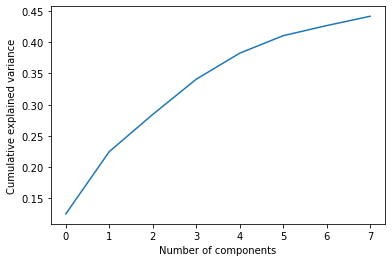

In [ ]:
#the plot helps understand how much variance is explained after SVD.

explained_var_ratio = model_rf_svd_cv.named_steps['svd'].explained_variance_ratio_

# Plot the explained variance ratio against the number of components
plt.plot(np.cumsum(explained_var_ratio))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

#### Model's comparison

In [ ]:
# Compare performance - train sets with cross-validation scoring against RMSE
rf_performance_cross_val = pd.concat([rf_cv, rf_svd_cv], axis=1)
# ---------
rf_performance_cross_val

,model_rf,model_rf_svd
r2,0.9614,0.8521
adj_r2,0.9588,0.8423
mean_cv_rmse,"31,396,504.0","31,455,569.8"
std_cv_rmse,"7,235,911.3","6,887,032.2"
coef_of_var,0.2305,0.2189


In [ ]:
# Compare performance - test sets
rf_performance_test = pd.concat([rf_test, rf_svd_test], axis=1)
# ---------
rf_performance_test

,model_rf,model_rf_svd
r2,0.6140,0.5398
adj_r2,0.4865,0.3877
rmse,"60,253,891.7","65,790,722.2"
mae,"5,218,108.6","7,724,874.3"
mape,0.6426,15.2028


# All models - performance

## Cross-validation on training set

In [ ]:
# Please note that the thousand separators may appear incorrectly for you - if that is the case, please modify the functions at the beginning of the file as mentioned in the comments of the functions
all_performance_cross_val = pd.concat([linear_performance_cross_val, rf_performance_cross_val, gb_performance_cross_val], axis=1)
# ---------
all_performance_cross_val

,model_linreg_f,model_ridge_f,model_svd_f,model_rf,model_rf_svd,base_gb,nodup_gb,catgroup_gb,flat_tuned_gb
r2,0.6545,0.4957,0.4755,0.9614,0.8521,0.7546,0.9287,0.9395,0.9969
adj_r2,0.6544,0.4956,0.4754,0.9588,0.8423,0.7545,0.9286,0.9394,0.9965
mean_cv_rmse,"94,765,183.8","82,310,965.2","82,698,018.7","31,396,504.0","31,455,569.8","85,822,880.6","58,504,264.1","54,633,112.1","26,642,268.7"
std_cv_rmse,"22,744,698.6","26,801,694.0","26,154,785.9","7,235,911.3","6,887,032.2","25,361,034.4","21,694,606.1","24,192,030.0","19,982,202.8"
coef_of_var,0.2400,0.3256,0.3163,0.2305,0.2189,0.2955,0.3708,0.4428,0.7500


## Evaluation on test set

In [ ]:
# Please note that the thousand separators may appear incorrectly for you - if that is the case, please modify the functions at the beginning of the file as mentioned in the comments of the functions
all_performance_test = pd.concat([linear_performance_test, rf_performance_test, gb_performance_test], axis=1)
# ---------
all_performance_test

,model_linreg_f,model_ridge_f,model_svd_f,model_rf,model_rf_svd,base_gb,nodup_gb,catgroup_gb,flat_tuned_gb
r2,0.5702,0.6283,0.6391,0.6140,0.5398,0.5037,0.4604,0.5816,0.9073
adj_r2,0.5697,0.6279,0.6387,0.4865,0.3877,0.5033,0.4589,0.5805,0.8496
rmse,"128,229,239.3","119,235,127.6","117,498,887.3","60,253,891.7","65,790,722.2","141,670,000.0","48,820,755.0","42,987,381.1","17,875,161.4"
mae,"40,203,041.0","29,436,624.2","30,138,338.3","5,218,108.6","7,724,874.3","27,204,562.1","8,949,026.6","8,729,483.5","3,291,717.6"
mape,125.3670,111.2556,116.1943,0.6426,15.2028,43.7782,40.5325,28.1006,4.1410
